In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def calculate_adx(high, low, close, window=14):
    """
    Calculates the Average Directional Index (ADX), +DI, and -DI.

    Args:
        high (pd.Series): Series of high prices.
        low (pd.Series): Series of low prices.
        close (pd.Series): Series of close prices.
        window (int): The lookback period for the calculation.

    Returns:
        pd.DataFrame: A DataFrame containing ADX, +DI, and -DI.
    """
    # Calculate True Range (TR)
    tr1 = high - low
    tr2 = abs(high - close.shift(1))
    tr3 = abs(low - close.shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = tr.ewm(alpha=1/window, adjust=False).mean()

    # Calculate Directional Movement (+DM, -DM)
    plus_dm = high.diff()
    minus_dm = low.diff().mul(-1)
    plus_dm[(plus_dm < 0) | (plus_dm <= minus_dm)] = 0
    minus_dm[(minus_dm < 0) | (minus_dm <= plus_dm)] = 0
    
    # Smooth the Directional Movements
    plus_di = 100 * plus_dm.ewm(alpha=1/window, adjust=False).mean() / atr
    minus_di = 100 * minus_dm.ewm(alpha=1/window, adjust=False).mean() / atr

    # Calculate Directional Index (DX) and ADX
    dx = 100 * (abs(plus_di - minus_di) / (plus_di + minus_di))
    adx = dx.ewm(alpha=1/window, adjust=False).mean()
    
    return pd.DataFrame({'ADX': adx, '+DI': plus_di, '-DI': minus_di})


In [9]:
# --- 1. Data Fetching ---
# Fetch historical data for NVIDIA (NVDA) for the specified period
nvda_data = yf.download('NVDA', start='2021-01-01', end='2025-08-31')


/var/folders/3n/c2cyvjmd52585bcd83mjw9dw0000gp/T/ipykernel_15911/1590488012.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nvda_data = yf.download('NVDA', start='2021-01-01', end='2025-08-31')
[*********************100%***********************]  1 of 1 completed


In [10]:
    
if isinstance(nvda_data.columns, pd.MultiIndex):
        # Option A – drop the outer level (works when only one ticker):
    nvda_data = nvda_data.droplevel(1, axis=1)


In [11]:

# --- 2. ADX Calculation ---
adx_data = calculate_adx(nvda_data['High'], nvda_data['Low'], nvda_data['Close'])
nvda_data = nvda_data.join(adx_data)



In [12]:

# --- 3. Threshold Analysis ---
# Calculate a data-driven threshold using the 75th percentile
# This means we define a "strong trend" as being in the top 25% of ADX values for this period.
adx_threshold = nvda_data['ADX'].quantile(0.75)

print(f"Standard ADX threshold for a strong trend is typically 25.")
print(f"The data-driven threshold (75th percentile) for NVDA in this period is: {adx_threshold:.2f}")


Standard ADX threshold for a strong trend is typically 25.
The data-driven threshold (75th percentile) for NVDA in this period is: 34.65


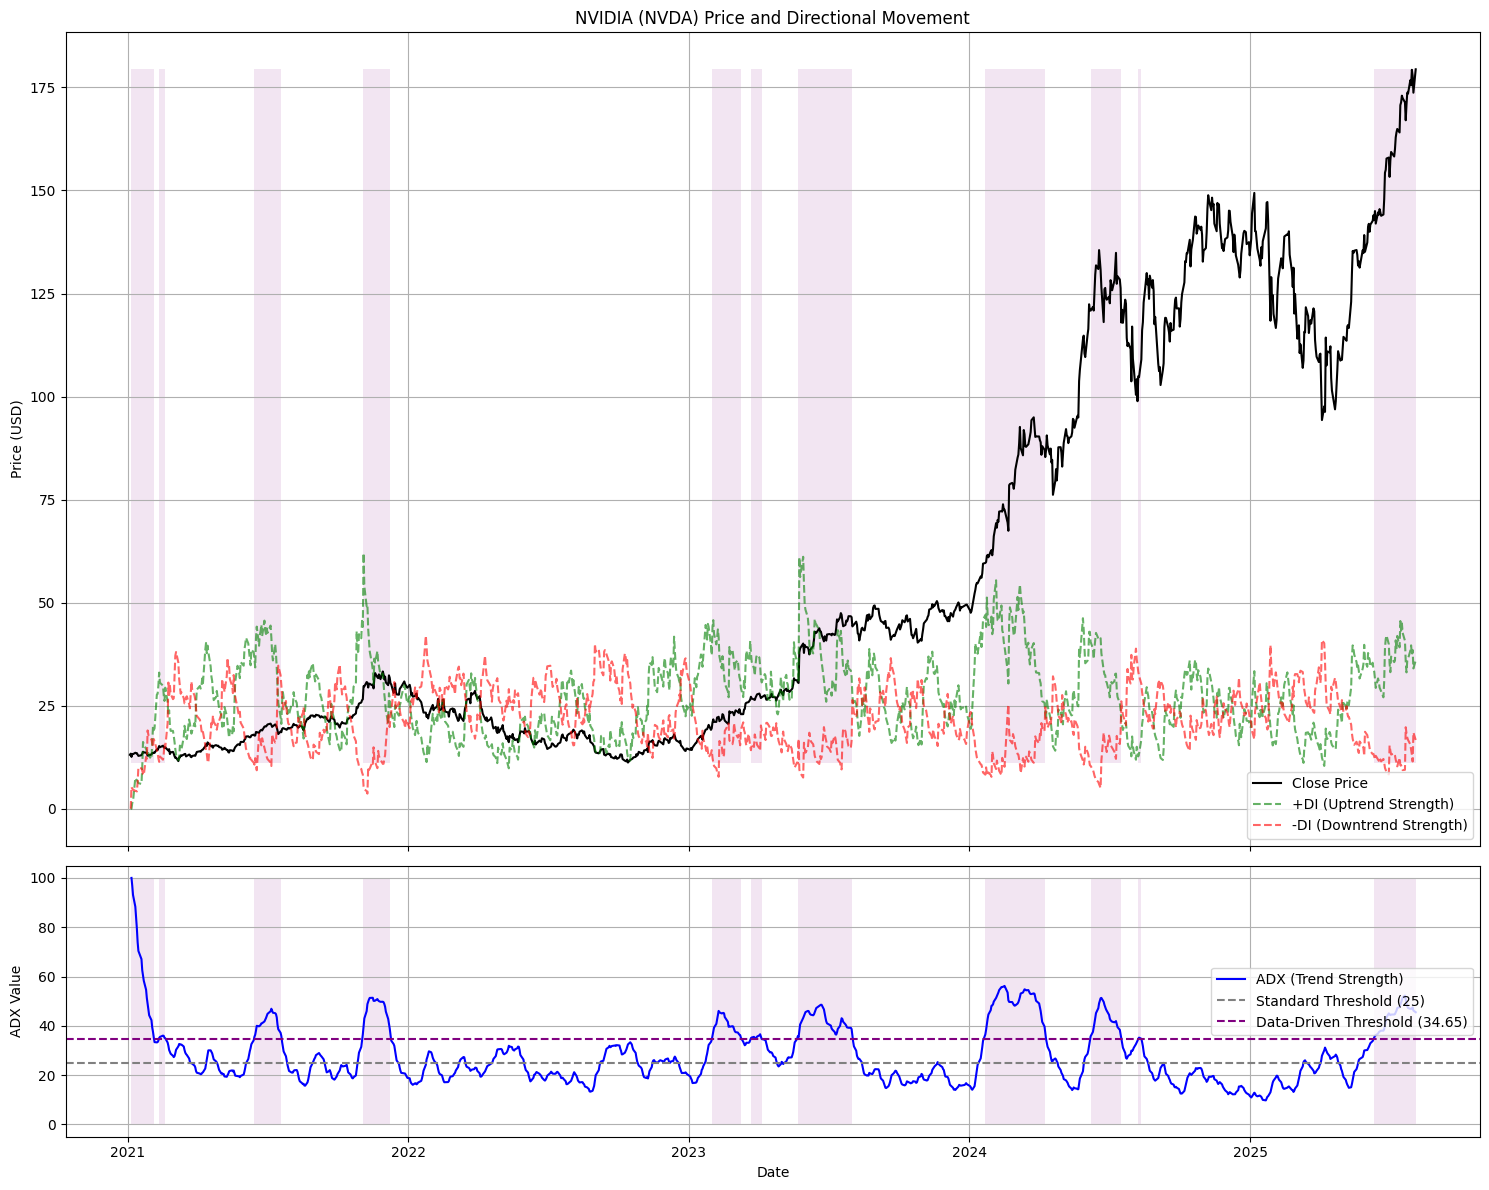

In [13]:
# --- 4. Visualization ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Plot 1: Price and Directional Indicators
ax1.plot(nvda_data.index, nvda_data['Close'], label='Close Price', color='black')
ax1.plot(nvda_data.index, nvda_data['+DI'], label='+DI (Uptrend Strength)', color='green', alpha=0.6, linestyle='--')
ax1.plot(nvda_data.index, nvda_data['-DI'], label='-DI (Downtrend Strength)', color='red', alpha=0.6, linestyle='--')
ax1.set_title('NVIDIA (NVDA) Price and Directional Movement')
ax1.set_ylabel('Price (USD)')
ax1.legend()
ax1.grid(True)

# Plot 2: ADX and Thresholds
ax2.plot(nvda_data.index, nvda_data['ADX'], label='ADX (Trend Strength)', color='blue')
ax2.axhline(25, linestyle='--', color='gray', label='Standard Threshold (25)')
ax2.axhline(adx_threshold, linestyle='--', color='purple', label=f'Data-Driven Threshold ({adx_threshold:.2f})')
ax2.set_ylabel('ADX Value')
ax2.set_xlabel('Date')
ax2.legend()
ax2.grid(True)

# Shade the areas where the trend is strong based on our custom threshold
strong_trend_periods = nvda_data['ADX'] > adx_threshold
ax1.fill_between(nvda_data.index, nvda_data['Close'].min(), nvda_data['Close'].max(), where=strong_trend_periods, facecolor='purple', alpha=0.1)
ax2.fill_between(nvda_data.index, 0, 100, where=strong_trend_periods, facecolor='purple', alpha=0.1)


plt.tight_layout()
plt.show()
